# SMC2017: Exercise set I

## Setup

In [123]:
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## I.1 Importance sampling

$q(x) = N(x; 0, 1)$ and $\pi(x) = U(x; [0, 4])$

a) $q(x) > 0$ for all $x$. This is important since $\pi(x) > 0$ for $x \in [0, 4]$

b) Implement an importance sampler

In [48]:
def target_exact(x):
    if x >= 0.0 and x <= 4.0:
        return 0.25
    else:
        return 0.0
    
def target_prop(x):
    if x >= 0.0 and x <= 4.0:
        return 1.0
    else:
        return 0.0

def imp_sample_exact(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the exact weights
    weights = np.vectorize(target_exact)(samples) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    
    return samples, weights

def imp_sample_prop(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the weights
    weights = np.vectorize(target_prop)(samples) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    # Normalize the weights
    weights_normalized = weights / np.sum(weights)
    
    return samples, weights, weights_normalized

Plot the resulting distribution as a weighted histogram

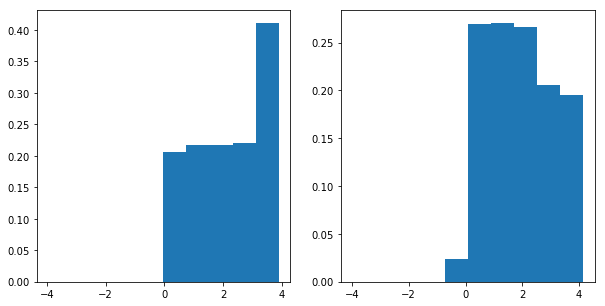

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Self-normalized
samples, weights, weights_normalized = imp_sample_prop(10000)
axs[0].hist(samples, bins=10, weights=weights_normalized, normed=True);

# Exact
samples, weights = imp_sample_exact(10000)
axs[1].hist(samples, bins=10, weights=weights, normed=True);

Problem: Often too little probability on the ends of the uniform probability, probably caused by tail behaviour of the normal distribution.

c) Check for bias

Calculate mean value of $\pi(x)$ through importance sampling. Theoretical value: 2

Average: 2.0115824172268195
Bias: 0.01158241722681953


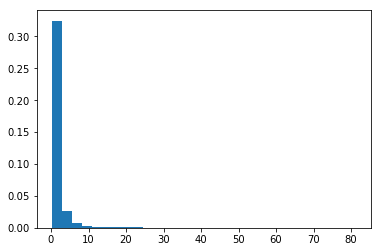

In [31]:
M = 100000
exp_vals = np.zeros((M,))

for i in range(M):
    samples, weights = imp_sample_exact(100)
    exp_vals[i] = np.mean(samples * weights)
    
print("Average: {}".format(exp_vals.mean()))
biases = exp_vals - 2
print("Bias: {}".format(biases.mean()))

fig, ax = plt.subplots()
ax.hist(exp_vals, bins=30, normed=True);

d) Informal derivation of the estimator
$$\widehat{Z} = \frac{1}{N} \sum_{i = 1}^N \widetilde{W}^i\quad\text{where}\quad\widetilde{W}^i = \frac{\widetilde{\pi}(X_i)}{q(X_i)}$$

We can write
$$Z = \int \widetilde{\pi}(x)\,\mathrm{d}x = \int \frac{\widetilde{\pi}(x)}{q(x)} q(x)\,\mathrm{d}x$$

Replace
$$q(x) \approx \frac{1}{N} \sum_{i = 1}^N \delta_{x^i}(x)\quad\text{and}\quad \omega(x) = \frac{\widetilde{\pi}(x)}{q(x)}$$
where $x^i$ are sampled from $q(x)$. This leads to
$$\widehat{Z} = \frac{1}{N} \sum_{i = 1}^{N} \omega(x^i)$$

e) Implement that estimator

In [39]:
M = 8000
Z_vals = np.zeros((M,))

for i in range(M):
    samples, weights, weights_normalized = imp_sample_prop(1000, loc=2, scale=2)
    Z_vals[i] = np.mean(weights)
    
print("Bias: {}".format(Z_vals.mean() - 4))
print("Variance: {}".format(Z_vals.var()))

Bias: -0.0006390923472849863
Variance: 0.008010708353046802


Moving the Gaussian more to the midpoint of the uniform distribution reduces the variance to almost zero. Moving it more below 0 or above 4 increases the variance a lot.

f) Bias of mean integral in case of self-normalized importance sampling

Average: 1.995859059940589
Bias: -0.004140940059410954


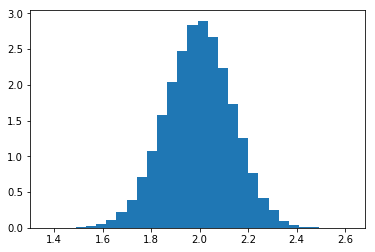

In [44]:
M = 100000
exp_vals = np.zeros((M,))

for i in range(M):
    samples, weights, weights_normalized = imp_sample_prop(200, scale=3)
    exp_vals[i] = np.nansum(samples * weights_normalized)
    
print("Average: {}".format(exp_vals.mean()))
biases = exp_vals - 2
print("Bias: {}".format(biases.mean()))

fig, ax = plt.subplots()
ax.hist(exp_vals, bins=30, normed=True);

g) Solution to what? The bias correction? Isn't that done anyway? The normalized weights sum to one as far as I can tell...

## I.2 Importance sampling in higher dimensions

Consider importance sampling in a $D$-dimensional space. Let the proposal $q(x) = N(x; 0, I_D)$ be the $D$-dimensional normal distribution and the target $\pi(x) = U(x; [-0.5, 0.5]^D)$. Exact evaluation of the target is allowed.

This means 
$$\pi(x) = \frac{1}{(0.5 - (-0.5))^D} \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i) = \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i)$$

In [92]:
def multivariate_uniform_pdf(x, a=-0.5, b=0.5):
    if np.alltrue(x >= a) and np.alltrue(x <= b):
        return 1
    else:
        return 0
    
def imp_sample(N, D):
    # Sample from the proposal
    samples = stats.multivariate_normal.rvs(np.zeros((D,)), np.identity(D), N)
    # Calculate exact weights
    weights = np.apply_along_axis(multivariate_uniform_pdf, 1, samples) / \
                stats.multivariate_normal.pdf(samples, mean=np.zeros((D,)), 
                                              cov=np.identity(D))
    
    return samples, weights

Create a histogram in two dimensions to see if the code works.

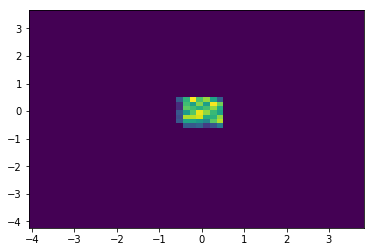

In [103]:
N = 8000
D = 2

fig, ax = plt.subplots()

samples, weights = imp_sample(N, D)
ax.hist2d(samples[:, 0], samples[:, 1], bins=50, weights=weights);

Iterate over the dimension and see how the proportion of non-zero weights develops.

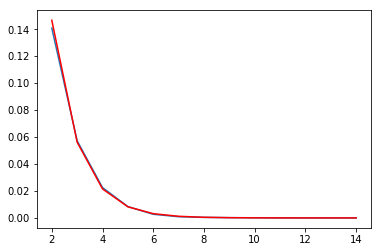

In [120]:
N = 10000

proportion = []
probability = []

for D in range(2, 15):
    samples, weights = imp_sample(N, D)
    proportion.append(len(weights[weights != 0.0]) / len(weights))
    probability.append(
        stats.mvn.mvnun(-0.5*np.ones((D,)), 0.5*np.ones((D,)), 
                        np.zeros((D,)), np.identity(D))[0])
    
proportion = np.array(proportion)
probability = np.array(probability)

fig, ax = plt.subplots()
ax.plot(range(2, 15), proportion);
ax.plot(range(2, 15), probability, 'r');

In [121]:
proportion

array([  1.40800000e-01,   5.72000000e-02,   2.25000000e-02,
         8.40000000e-03,   2.70000000e-03,   9.00000000e-04,
         4.00000000e-04,   2.00000000e-04,   1.00000000e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

It seems that the effective amount of weights with non-zero value very rapidly converges to zero. It is so fast that it could be exponential decrease.

Theoretically the weights are
$$\omega(x^i) = \frac{\prod_{j = 1}^D I_{[-0.5, 0.5]}(x^i_j)}{\frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x^i\|^2\right)}.$$

With increasing dimension the probability of all components of the sample to be inside of the interval $[-0.5, 0.5]$ get lower and lower. Thus the number of zero samples increases.

The probability for all components of a sample from the $D$-dimensional normal distribution to be between $-0.5$ and $0.5$ is
$$P(-0.5 \leq x \leq 0.5) = P(x \leq 0.5) - P(x < -0.5) = 2 \cdot \Phi_D(0.5) - 1$$.

Here it holds that
$$
\begin{align}
\Phi_D(z) &= \int_{-\infty}^{z_1}\dots\int_{-\infty}^{z_D} \frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x\|^2\right)\,\mathrm{d}x = \\
&= \frac{1}{(2\pi)^{D/2}} \int_{-\infty}^{z_1} \exp\left(-\frac{1}{2} x_1^2\right)\,\mathrm{d}x_1\,\dots\,\int_{-\infty}^{z_D} \exp\left(-\frac{1}{2} x_D^2\right)\,\mathrm{d}x_D
\end{align}
$$
and thus
$$\Phi_D(0.5) = \Phi_1(0.5)^D \rightarrow 0\quad\text{for}\quad D \rightarrow \infty$$
since $\Phi_1(0.5) < 1$. This explains why the decrease is exponentially fast.

In [122]:
stats.norm.cdf(0.5)

0.69146246127401312

## I.3 An important numerical aspect

Skip for now...

## I.4 Bootstrap particle filter for the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_t|x_{t - 1} &\sim N(x_t; \phi \cdot x_{t - 1}, \sigma^2) \\
y_t|x_t &\sim N(y_t; 0, \beta^2 \cdot \exp(x_t))
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

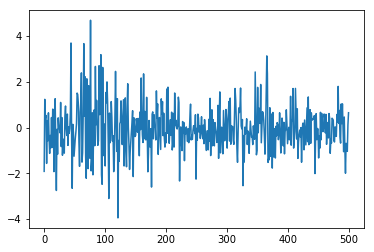

In [133]:
data = pd.read_csv('..\\base_material\\seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
fig, ax = plt.subplots()
ax.plot(data.logreturn)

Assume the parameter vector is given as $\theta = (0.98, 0.16, 0.70)$. 